# 3. Numpy
- A number of arrays (vectors, matrices, images), linear algebra

## 0. Import Packages

In [125]:
from numpy import array
from PIL import *
from pylab import *
import os
import pickle
from IPython.display import display, Math, Latex

warnings.filterwarnings(action='ignore')
# warnings.filterwarnings(action='default')

## 1. Array

In [7]:
img = array(Image.open('img/alcohol2.jpg'))
print("Shape of img :", img.shape)
print("Type of img :", img.dtype)

Shape of img : (960, 720, 3)
Type of img : uint8


In [8]:
img_gray = array(Image.open("img/alcohol2.jpg").convert('L'), 'f')  # float
print("Shape of img :", img_gray.shape)
print("Type of img :", img_gray.dtype)

Shape of img : (960, 720)
Type of img : float32


In [11]:
# value = img[i, j, k]  

# img[i, :] = img[j, :]     # set row i with row j  
# img[:, i] = 100     # set all columns i to 100  
# img[:100, :50].sum()     # sum of the first 100 rows and 50 columns  
# img[50:100, 50:100]     # row 50-100, coi 50-100  
# img[i].mean()     # average of row i  
# img[:, -1]     # last column  
# img[ -2, :] (or img[-2])     # second to last row  

## 2. Graylevel Transforms

In [17]:
img = array(Image.open("img/alcohol2.jpg").convert('L'))

img1 = 255 - img  # invert graylevels
img2 = (100/255) * img + 100  # 100...200
img3 = 255 * (img/255) ** 2  # quadratic ft

print("[0] :", img.min(), img.max())
print("[1] :", img1.min(), img1.max())
print("[2] :", int(img2.min()), int(img2.max()))
print("[3] :", int(img3.min()), int(img3.max()))

[0] : 1 255
[1] : 0 254
[2] : 100 200
[3] : 0 255


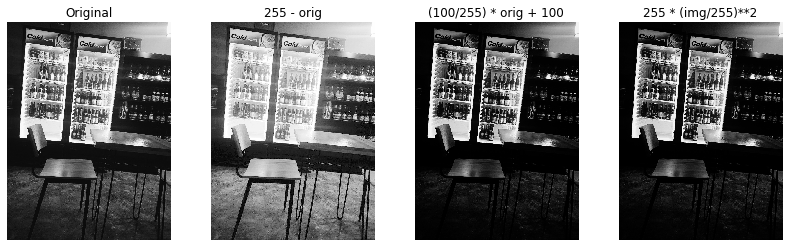

In [35]:
rcParams["figure.figsize"] = (14,4)

figure()
subplot(1,4,1)

imshow(img, cmap='gray')
title("Original")
axis("off")

subplot(1,4,2)
imshow(img2, cmap='gray')
title("255 - orig")
axis("off")

subplot(1,4,3)
imshow(img3, cmap='gray')
title("(100/255) * orig + 100")
axis("off")

subplot(1,4,4)
imshow(img3, cmap='gray')
title("255 * (img/255)**2")
axis("off")

show()

In [28]:
# reverse of the array() transformation
pil_im = Image.fromarray(img)

# change the type
pil_im = Image.fromarray(uint8(img))

## 3. Image Resizing

In [29]:
def imresize(img, size) : 
    pil_im = Image.fromarray(uint8(img))
    
    return array(pil_im.resize(size))

## 4. Histogram Equalization
- Graylevel transform : flatten graylevel histogram of an image -> normalize image intensity
- Transform function : **cdf**

formula for creating the histogram below :


<IPython.core.display.Math object>

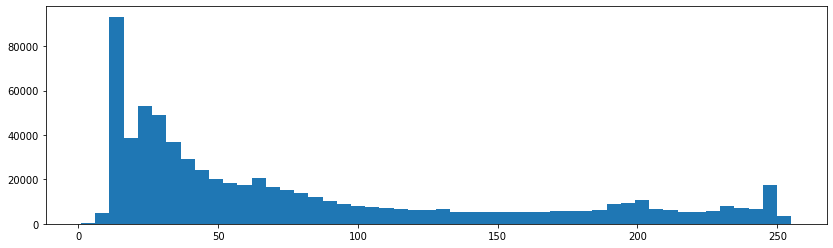

In [154]:
print('formula for creating the histogram below :')
display(Math(r'P_x(j) = \sum_{i=0}^{j} P_x(i)'))

img = array(Image.open('img/alcohol2.jpg').convert('L'))
flat = img.flatten()
plt.hist(flat, bins = 50)
plt.show()

In [112]:
def histeq(img, nbr_bins = 256) : 
    
    # get histogram
    imhist, bins = histogram(img.flatten(), nbr_bins, normed = True)
    cdf = imhist.cumsum()  # cdf
    cdf = 255 * cdf / cdf[-1]  #normalize
    
    # use linear interpolation of cdf to find new pixel value
    img2 = interp(img.flatten(), bins[:-1], cdf)
    
    return img2.reshape(img.shape), cdf

In [113]:
img = array(Image.open('img/alcohol2.jpg').convert('L'))
img2, cdf = histeq(img)

formula to calculate cumulation sum below :


<IPython.core.display.Math object>

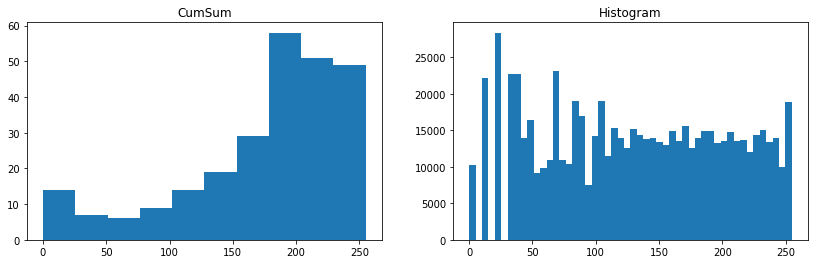

In [153]:
print('formula to calculate cumulation sum below :')
display(Math(r's_k = \sum_{j=0}^{k} {\frac{n_j}{N}}'))

rcParams["figure.figsize"] = (14,4)

subplot(1,2,1)
plt.hist(cdf)
title("CumSum")

subplot(1,2,2)
flat = img2.flatten()
plt.hist(flat, bins = 50)
title("Histogram")
# we see a much more evenly distributed histogram

show()

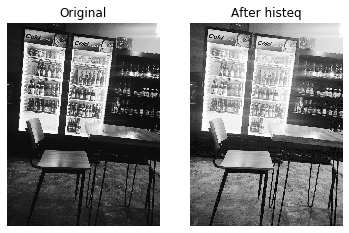

In [41]:
rcParams["figure.figsize"] = (6,4)

figure()
subplot(1,2,1)

imshow(img, cmap='gray')
title("Original")
axis("off")

subplot(1,2,2)

imshow(img2, cmap='gray')
title("After histeq")
axis("off")

show()

- The contrast increases and the details of the dark regions appear clearly.

## 5. Averaging Images

In [42]:
def compute_average(imlist) : 
    average_im = array(Image.open(imlist[0]), 'f')
    
    for im_name in imlist[1:] :
        try :
            average_im += array(Image.open(imname))
        except :
            print(imname + '...skipped')
    average_im /= len(imlist)
    
    return array(average_im, 'uint8')

## 6. PCA (Principal Component Analysis)

In [79]:
def pca(X) : 
    # input : flattened arrays in row / return : projection matrix
    
    # get dims
    num_data, dim = X.shape
    
    # centers the data
    mean_X = X.mean(axis = 0)
    X = X - mean_X
    
    # either compact trick or SVD
    if dim > num_data :
        
        # compact trick
        M = dot(X, X.T)  # covariance
        e, EV = linalg.eigh(M)  # eigenvalues and eigenvectors
        tmp = dot(X.T, EV).T  # compact trick
        V = tmp[::-1]  # reverse since last eigenvectors are the ones we want
        S = sqrt(e)[::-1]  # reverse since eigenvalues are in increasing order
        
        for i in range(V.shape[1]) : 
            V[:, i] /= S
            
    else :
        # SVD (Singular Value Decomposition)
        U, S, V = linalg.svd(x)
        V = V[: num_data]  # only makes sense to return the first num_data
                
    # projection matrix, variance, mean
    return V, S, mean_X

In [80]:
def get_jpg_imlist(path) : 
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.jpg')]

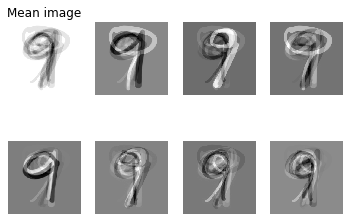

In [114]:
imlist = get_jpg_imlist('img/nine')
img = array(Image.open(imlist[0]))
m, n = img.shape[0:2]
imnbr = len(imlist)

im_matrix = array([array(Image.open(img).convert('L')).flatten() for img in imlist], 'f')

# pca
V, S, im_mean = pca(im_matrix)

# show the images
figure()
gray()


subplot(2,4,1)
imshow(im_mean.reshape(m,n))
title("Mean image")
axis('off')

for i in range(7) :
    subplot(2,4,i+2)
    imshow(V[i].reshape(m,n))
    axis('off')
# Directions with most variation

show()

## 7. Pickle Module
- Save results or data

In [118]:
# save mean and pca
f = open('font_pca_models.pkl', 'wb')
pickle.dump(im_mean, f)
pickle.dump(V, f)
f.close()

# same
with open('font_pca_models.pkl', 'wb') as f :
    pickle.dump(im_mean, f)
    pickle.dump(V, f)

In [119]:
# load mean and pca
f = open('font_pca_models.pkl', 'rb')
im_mean = pickle.load(f)
V = pickle.load(f)
f.close()

# same
with open('font_pca_models.pkl', 'rb') as f :
    im_mean = pickle.load(f)
    V = pickle.load(f)